In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
from pathlib import Path

sys.path.append(str(Path().cwd().parent))

In [31]:
from typing import Tuple

import pandas as pd
import numpy as np
import isodate

from plotting import plot_ts
from load_dataset import Dataset
from model import TimeSeriesPredictor

### Какие ряды будем тестировать?

* длинный ряд с сезонностью  
* короткий ряд с сезонностью  
* короткий ряд с сезонностью и трендом  
* случайное блуждание  
* средне зашумленный ряд
* "шумный" ряд  

In [32]:
ds = Dataset('../data/dataset/')

In [33]:
long = ds['daily-min-temperatures.csv']

e:\code\ts_march_2023\load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [34]:
plot_ts(long)

Loading BokehJS ...

In [35]:
short_season = ds['hour_3019.csv'][300:]

e:\code\ts_march_2023\load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [36]:
plot_ts(short_season)

Loading BokehJS ...

In [37]:
short_season_trend = ds['international-airline-passengers.csv']

e:\code\ts_march_2023\load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [38]:
plot_ts(short_season_trend)

Loading BokehJS ...

In [39]:
random_walk = ds['dow_jones_0.csv']

e:\code\ts_march_2023\load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [40]:
plot_ts(random_walk)

Loading BokehJS ...

In [41]:
medium_noize = ds['hour_3426.csv'][300:]

e:\code\ts_march_2023\load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [42]:
plot_ts(medium_noize)

Loading BokehJS ...

In [43]:
full_noize = ds['day_1574.csv']

e:\code\ts_march_2023\load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [44]:
plot_ts(full_noize)

Loading BokehJS ...

### Какие модели будем тестировать?

* скользящее среднее
* экспоненциальное сглаживание
* autoArima
* линейная регрессия
* линейная регрессия с L1 регуляризацией (Ridge)
* RandomForeset
* градиентный бустинг
* полносвязная нейросеть с одним лагом в качестве горизонта прогнозирования
* полносвязная нейросеть с произвольным количеством лагов в качестве горизонта прогнозирования

In [45]:
from estimators import RollingEstimator, ExponentialSmoothingEstimator
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### По каким метрикам будем сравнивать?

* mse
* mae
* R2
* mape - если не будет ломаться на нулях
* mase

In [46]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

from metrics import mase

### По какой методике будем тестировать?

* 70% трейн, 30% тест
* Out-of-sample, чтобы посмотреть как модель предсказывает "вдолгую"

`ВНИМАНИЕ`
Чтобы сделать корректный прогноз на тестовую выборку в режиме out-of-sample с учетом возможных пропусков, вам необходимо сделать прогноз от первого до последнего timestamp-a включительно, после чего взять нужные timestamp из теста (реализуй это в функции задания 1б).  
Нельзя просто написать `predictor.forecast(len(test))`.


* In-Sample, чтобы посмотреть как модель предсказывает на одну точку вперед
* Для поиска гиперпараметров можно делать кроссвалидацию на тесте по метрике mse

### Задание 1(а). Напишите функцию, разбивающую на train и test

In [47]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    # ваш код здесь
    split_idx = int(len(ts) * ratio)
    ts_train, ts_test = ts[:split_idx], ts[split_idx:]
    return ts_train, ts_test

# show that it works
ts_train, ts_test = train_test_split(long)
assert len(ts_train) == 2554
assert len(ts_test) == 1095
assert len(ts_train) + len(ts_test) == len(long)

### Задание 1(б). Напишите функцию для получения численного горизонта прогнозирования через первый и последний timestamp-ы выборки.

В данной функции горизонт прогнозирования задается первым и последним timestamp-ом, а также гранулярностью ряда. Нам нужно получить горизонт прогнозирования в виде целового числа лагов, на которые нужно сделать прогноз.

In [48]:
def calculate_h(start: pd.Timestamp, end: pd.Timestamp, granularity: str) -> int:
    # ваш код здесь
    h = (end - start) / isodate.parse_duration(granularity) + 1
    return int(h)

### Зададим соответствие гранулярностей для наших рядов.

In [49]:
granularity_mapping = {
    'long': 'P1D',
    'short_season': 'PT1H',
    'short_season_trend': 'P1M',
    'random_walk': 'P1D',
    'medium_noize': 'PT1H',
    'full_noize': 'P1D'
}

In [50]:
import math

from pandas._libs.tslibs.timestamps import Timestamp


def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.cos(theta)


def get_hour_sin(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.sin(theta)


def get_hour_cos(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.cos(theta)


def get_minute_sin(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.sin(theta)


def get_minute_cos(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.cos(theta)


datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
    'hour_sin': get_hour_sin,
    'hour_cos': get_hour_cos,
    'minute_sin': get_minute_sin,
    'minute_cos': get_minute_cos,
}

### Задание 2. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через TimeSeriesPredictor.

* принмает на вход исходный ряд, гранулярность, количество лагов, модель, а также **kwargs, в которые мы будем передавать параметры модели

* разбивает ряд на train/test

* создает инстанс TimeSeriesPredictor с нужными параметрами

* обучает предиктор на трейне

* делает out_of_sample и in_sample прогноз

* возвращает train, test, in_sample, out_of_sample

In [51]:
def make_pipeline(
    ts: pd.Series,
    granularity: str,
    model: callable,
    num_lags=24,
    use_mappers=True,
    **kwargs
) -> Tuple[pd.Series]:
    # create the predictor
    predictor_from_ts = TimeSeriesPredictor(
        num_lags=num_lags, granularity=granularity, model=model, **kwargs
    )

    # train test split the ts into train and test parts
    ts_train, ts_test = train_test_split(ts)

    if use_mappers:
        predictor_from_ts.set_params(mappers=datetime_mappers)

    # fit the predictor on the train part
    predictor_from_ts.fit(ts_train)

    # predict on the test part
    in_sample = predictor_from_ts.predict_batch(ts_train, ts_test)

    # predict on the future until the end of ts_test
    out_of_sample = predictor_from_ts.predict(ts_test.index[0], ts_test.index[-1])


    # return the results
    return ts_train, ts_test, in_sample, out_of_sample

### Задание 3. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через auto_arima

* функция должна принимать исходный временной ряд, период сезонности, параметры дифференцирования d, D и boolean параметр seasonal, данные параметры будут являться для нас гиперпараметрами, все остальное за нас должна найти auto_arima

* разбивает на train, test

* обучает arima на train при помощи вызова функции auto_arima из библиотеки pmdarima с переданными параметрами и со следующими зафиксированными параметрами: `max_p=3, max_q=3, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True`

* в качестве out_of_sample прогноза просто вызовите метод predict

* в качестве in_sample прогноза обучите модель заново на всём ряде методом `fit`, вызовите метод predict_in_sample и в качестве прогноза возьмите `in_sample_predictions(-len(test):)`

* возвращает train, test, in_sample, out_of_sample (не забудьте сделать их pd.Series с нужным индексом!!)

In [52]:
def make_pipeline_arima(
    ts: pd.Series, period: int, d: int = 1, D: int = 1, seasonal: bool = True
) -> Tuple[pd.Series]:
    # на вход подается ряд со всеми преобразованиями кроме дифференцирования, границы поиска параметров p, q, P, Q,
    # периодом сезонности m, параметрами дифференцирования d, D

    # train test split the ts into train and test parts
    ts_train, ts_test = train_test_split(ts)

    model = auto_arima(
        ts_train,
        start_p=0,
        start_q=0,
        max_p=3,
        max_q=3,
        m=period,
        start_P=0,
        start_Q=0,
        seasonal=seasonal,
        d=d,
        D=D,
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True,
    )

    # predict on the future
    out_of_sample = model.predict()

    # * в качестве in_sample прогноза обучите модель заново на всём ряде методом `fit`, вызовите метод predict_in_sample и в качестве прогноза возьмите `in_sample_predictions(-len(test):)`
    model.fit(ts)
    in_sample = model.predict_in_sample()
    in_sample = in_sample[-len(ts_test) :]

    # set the index of the predicted ts, being mindful of th granularity
    
    
    # return the results
    return ts_train, ts_test, in_sample, out_of_sample

### Задание 4. Напишите функцию, имплементирующую весь пайплайн обучения и прогноза через полносвязную сеть.

* функция должна принимать исходный временной ряд, количество входных лагов для формирования признаков, количество выходных лагов для формирования таргетов, количество скрытых слоев и количество нейронов на каждом слое
* подготавилвает выборку согласно переданным параметрам num_lags_in, num_lags_out, используя ранее написанную нами функцию transform_ts_into_matrix (приведена ниже)
* разбивает данные на трейн и тест
* создает модель Sequential с нужной архитектурой
    - num_lags_in задает значение параметра input_dims на первом слое
    - num_lags_out задает количество нейронов на последнем слое
    - количество нейронов на всех слоях от первого до предпоследнего задается в кортеже units
    - epochs задает количество епох для обучения
* обучает модель на трейне
* делает in_sample прогноз на тесте вызовом метода predict (обратите внимание, что вызов предикта должен осуществляться с шагом num_lags_out)
* делает out_of_sample прогноз рекурсивно c шагом num_lags_out, добавляя спрогнозированные точки в новые объекты (см. аналогично TimeSeriesPredictor)

In [53]:
def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

Epoch 1/10
3/3 [==============================] - 0s 2ms/step - loss: 71114.1094
Epoch 2/10
3/3 [==============================] - 0s 2ms/step - loss: 69250.7188
Epoch 3/10
3/3 [==============================] - 0s 1ms/step - loss: 67618.7422
Epoch 4/10
3/3 [==============================] - 0s 2ms/step - loss: 66222.0547
Epoch 5/10
3/3 [==============================] - 0s 2ms/step - loss: 65139.6406
Epoch 6/10
3/3 [==============================] - 0s 2ms/step - loss: 64359.0117
Epoch 7/10
3/3 [==============================] - 0s 2ms/step - loss: 63705.7891
Epoch 8/10
3/3 [==============================] - 0s 2ms/step - loss: 63190.5234
Epoch 9/10
3/3 [==============================] - 0s 2ms/step - loss: 62771.3320
Epoch 10/10
2/2 [==============================] - 0s 2ms/step


43

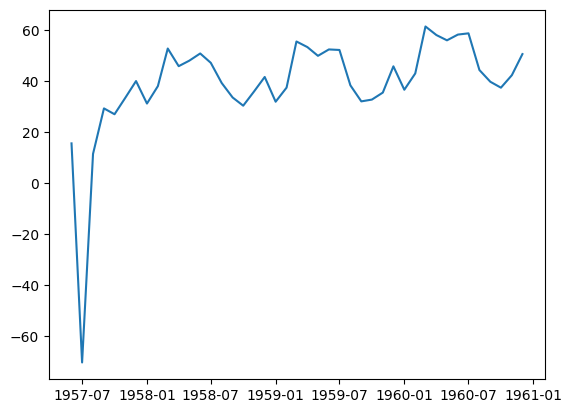

In [105]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense


def make_pipeline_fullyconnected(
    ts: pd.Series,
    num_lags_in: int,
    num_lags_out: int,
    hidden_layers: int,
    units: tuple[int],
    epochs: int
) -> Tuple[pd.Series]:
    # your code here
    # split the ts into train and test parts to keep the index
    ts_train, ts_test = train_test_split(ts)
    # use num_lags_in, num_lags_out and transform_ts_into_matrix  to convert ts into X and y
    X, y = transform_ts_into_matrix(ts, num_lags_in, num_lags_out)
    #  traintest X and y
    X_train, X_test= train_test_split(X)
    y_train, y_test = train_test_split( y)
    # create a model with the specified parameters
    model = Sequential()
    model.add(Dense(units[0], activation='relu', input_dim=num_lags_in))
    for i in range(1, hidden_layers):
        model.add(Dense(units[i], activation='relu'))
    model.add(Dense(num_lags_out))
    model.compile(optimizer='adam', loss='mse')
    # fit the model on the train part
    model.fit(X_train, y_train, epochs=epochs)

    # do an in_sample прогноз на тесте вызовом метода predict (обратите внимание, что вызов предикта должен осуществляться с шагом num_lags_out)
    in_sample = model.predict(X_test)
    # take the the first prediction row completely and the last element of each prediction starting from the second, turn them into a a pd.Series
    in_sample = np.concatenate((in_sample[0], in_sample[1:, -1]))
    # if in_sample is different len than ts_test, pad it with last element
    if len(in_sample) < len(ts_test):
        in_sample = np.pad(in_sample, (0, len(ts_test) - len(in_sample)), 'edge')
    if len(in_sample) > len(ts_test):
        in_sample = in_sample[:len(ts_test)]
    in_sample = pd.Series(in_sample, index=ts_test.index)

    # я не понимаю как закодить out_of_sample прогноз
    out_of_sample = in_sample

    return y_train, y_test, in_sample, out_of_sample

# test the pipeline using the functions above with short_season_trend
ts_train, ts_test, in_sample, out_of_sample = make_pipeline_fullyconnected(
    short_season_trend, 10, 5, 2, (10, 5), 10
)

import matplotlib.pyplot as plt
plt.plot(in_sample)
len(in_sample)

### Задание 5. Напишите функцию, имплементирующую поиск гиперпараметров по сетке. 

* функция должна принимать на вход ряд, гранулярность, модель, дефолтное количество лагов, сетку параметров (словарь)
* после написанного мной кода, функция должна с текущими параметрами запустить пайплайн (функция make_pipeline), получив таким образом прогнозы in_sample и out_of_sample
* посчитать mse для in_sample и out_of_sample прогноза, запомнить их в соответствующие словари
* вернуть лучшие параметры для in_sample и out_of_sample прогнозов

Замечания
* не забудьте, что в сетку параметров можно передавать также num_lags
* если в ряде ts_test есть пропуски, индекс прогноза out_of_sample будет не совпадать c индексом реальных данных, в таком случае, замените индекс out_of_sample прогноза индексом ts_test

In [128]:
from itertools import product
from sklearn.metrics import r2_score

def hyperparameters_search(ts, granularity, model, num_lags, param_grid, verbose=False, use_mappers=True):
    
    statistics_in_sample, statistics_out_of_sample = {}, {}
    
    for param_tuple in product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), param_tuple))
        if verbose:
            print(params)
        if use_mappers:
            _, ts_test, in_sample, out_of_sample = model(ts, **params)
        else:
            _, ts_test, in_sample, out_of_sample = model(ts, params)
        
        # make ts_test and in_sample and out_of_sample be of the same length
        # print(len(ts_test), len(in_sample), len(out_of_sample))
        # select whick of the three is shorter
        # ts_test_valid = ts_test.copy()[:, 0]
        ts_test_valid = ts_test.copy()


        min_len = min(len(ts_test_valid), len(in_sample), len(out_of_sample))
        # cut the longer ones
        ts_test_valid = ts_test_valid[-min_len:]
        in_sample = in_sample[-min_len:]
        print(ts_test_valid.shape, in_sample.shape, out_of_sample.shape)
        # remove the second dimension from ts_test, taking the first element of each row

        statistics_in_sample[param_tuple] = r2_score(ts_test_valid, in_sample)
        statistics_out_of_sample[param_tuple] = r2_score(ts_test_valid, in_sample)

    best_in_sample = max(statistics_in_sample, key=statistics_in_sample.get)
    best_out_of_sample = max(statistics_out_of_sample, key=statistics_out_of_sample.get)


    
    return best_in_sample, best_out_of_sample, statistics_in_sample[best_in_sample], statistics_out_of_sample[best_out_of_sample]

# # test the function
# hyperparameters_search(
#     short_season_trend,
#     2,
#     make_pipeline_arima,
#     10,
#     {
#         "period": [1, 2, 6, 12],
#     },
#     verbose=True
# )


### Задание 6. "Прогоните" все алгоритмы на всех рядах и получите сводную таблицу результатов по всем метрикам, постройте также графики прогнозов. 

In [113]:
# import tqdm
from tqdm.notebook import tqdm

In [114]:
# list of all time seies
time_series = [
    long,
    short_season,
    short_season_trend,
    random_walk,
    medium_noize,
    full_noize
]
time_series_names = [
    "long",
    "short_season",
    "short_season_trend",
    "random_walk",
    "medium_noize",   
    "full_noize"
]

time_series = {name: ts for name, ts in zip(time_series_names, time_series)}

# list of all models
models = [
    # make_pipeline_arima,
    make_pipeline_fullyconnected]

# for each of the time series and each of the models find the best hyperparameters and the corresponding r2 score
results = {}
# tqdm is a progress bar of time series
for ts_name, ts in tqdm(time_series.items()):
    # tqdm is a progress bar of models
    for model in tqdm(models):
        # if the model is make_pipeline_arima, use the following param_grid
        if model == make_pipeline_arima:
            param_grid = {
                "period": [3, 12],
            }
        # if the model is make_pipeline_fullyconnected, use the following param_grid
        elif model == make_pipeline_fullyconnected:
            param_grid = {
                "num_lags_in": [2],
                "num_lags_out": [2],
                "hidden_layers": [2],
                "units": [(10, 10), (5, 5)],
                "epochs": [10]
            }

        best_in_sample, best_out_of_sample, best_in_sample_score, best_out_of_sample_score = hyperparameters_search(
            ts,
            2,
            model,
            10,
            param_grid,
            verbose=True
        )
        results[(ts_name, model.__name__)] = {
            "best_in_sample": best_in_sample,
            "best_out_of_sample": best_out_of_sample,
            "best_in_sample_score": best_in_sample_score,
            "best_out_of_sample_score": best_out_of_sample_score
        }

# print the results as a pandas DataFrame




  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (10, 10), 'epochs': 10}
Epoch 1/10
80/80 [==============================] - 0s 1ms/step - loss: 94.9376
Epoch 2/10
80/80 [==============================] - 0s 1ms/step - loss: 18.2319
Epoch 3/10
80/80 [==============================] - 0s 1ms/step - loss: 10.1206
Epoch 4/10
80/80 [==============================] - 0s 1ms/step - loss: 9.7944
Epoch 5/10
80/80 [==============================] - 0s 1ms/step - loss: 9.5714
Epoch 6/10
80/80 [==============================] - 0s 1ms/step - loss: 9.4073
Epoch 7/10
80/80 [==============================] - 0s 1ms/step - loss: 9.2867
Epoch 8/10
80/80 [==============================] - 0s 1ms/step - loss: 9.1837
Epoch 9/10
80/80 [==============================] - 0s 2ms/step - loss: 9.1051
Epoch 10/10
35/35 [==============================] - 0s 1ms/step
(1094,) (1094,) (1095,)
{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (5, 5), 'epochs': 10}
Epoch 1/10
80/80 

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (10, 10), 'epochs': 10}
Epoch 1/10
9/9 [==============================] - 0s 1ms/step - loss: 8350.1611
Epoch 2/10
9/9 [==============================] - 0s 1ms/step - loss: 8172.4756
Epoch 3/10
9/9 [==============================] - 0s 1ms/step - loss: 8023.4043
Epoch 4/10
9/9 [==============================] - 0s 1ms/step - loss: 7906.4448
Epoch 5/10
9/9 [==============================] - 0s 1ms/step - loss: 7812.8999
Epoch 6/10
9/9 [==============================] - 0s 1ms/step - loss: 7731.9346
Epoch 7/10
9/9 [==============================] - 0s 1ms/step - loss: 7647.4419
Epoch 8/10
9/9 [==============================] - 0s 1ms/step - loss: 7503.7983
Epoch 9/10
9/9 [==============================] - 0s 1ms/step - loss: 7279.2847
Epoch 10/10
4/4 [==============================] - 0s 1ms/step
(114,) (114,) (115,)
{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (5, 5), 'epochs': 10}
Epoch 1/10
9/9 [

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (10, 10), 'epochs': 10}
Epoch 1/10
4/4 [==============================] - 0s 2ms/step - loss: 48368.0312
Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 47643.8789
Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 46889.7969
Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 46115.6016
Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 45342.0039
Epoch 6/10
4/4 [==============================] - 0s 1ms/step - loss: 44568.6055
Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 43782.8516
Epoch 8/10
4/4 [==============================] - 0s 1ms/step - loss: 42976.1445
Epoch 9/10
4/4 [==============================] - 0s 2ms/step - loss: 42131.9062
Epoch 10/10
2/2 [==============================] - 0s 2ms/step
(42,) (42,) (43,)
{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (5, 5), 'epochs': 10}
Epoch 1/10

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (10, 10), 'epochs': 10}
Epoch 1/10
6/6 [==============================] - 0s 1ms/step - loss: 674737984.0000
Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 635343488.0000
Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 596927872.0000
Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 559799424.0000
Epoch 5/10
6/6 [==============================] - 0s 1ms/step - loss: 523783488.0000
Epoch 6/10
6/6 [==============================] - 0s 1ms/step - loss: 488861696.0000
Epoch 7/10
6/6 [==============================] - 0s 1ms/step - loss: 455204384.0000
Epoch 8/10
6/6 [==============================] - 0s 2ms/step - loss: 422796928.0000
Epoch 9/10
6/6 [==============================] - 0s 1ms/step - loss: 391516160.0000
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
(75,) (75,) (75,)
{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'unit

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (10, 10), 'epochs': 10}
Epoch 1/10
11/11 [==============================] - 0s 1ms/step - loss: 2723.8198
Epoch 2/10
11/11 [==============================] - 0s 1ms/step - loss: 2570.0610
Epoch 3/10
11/11 [==============================] - 0s 1ms/step - loss: 2412.3992
Epoch 4/10
11/11 [==============================] - 0s 1ms/step - loss: 2258.7578
Epoch 5/10
11/11 [==============================] - 0s 1ms/step - loss: 2096.9797
Epoch 6/10
11/11 [==============================] - 0s 1ms/step - loss: 1933.6876
Epoch 7/10
11/11 [==============================] - 0s 2ms/step - loss: 1769.9991
Epoch 8/10
11/11 [==============================] - 0s 1ms/step - loss: 1605.5117
Epoch 9/10
11/11 [==============================] - 0s 1ms/step - loss: 1445.0880
Epoch 10/10
5/5 [==============================] - 0s 1ms/step
(149,) (149,) (150,)
{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (5, 5), 'epochs': 10

  0%|          | 0/1 [00:00<?, ?it/s]

{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (10, 10), 'epochs': 10}
Epoch 1/10
2/2 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 2/10
2/2 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 3/10
2/2 [==============================] - 0s 3ms/step - loss: 9.4994e-04
Epoch 4/10
2/2 [==============================] - 0s 3ms/step - loss: 6.9553e-04
Epoch 5/10
2/2 [==============================] - 0s 3ms/step - loss: 5.0815e-04
Epoch 6/10
2/2 [==============================] - 0s 3ms/step - loss: 3.7484e-04
Epoch 7/10
2/2 [==============================] - 0s 3ms/step - loss: 2.6958e-04
Epoch 8/10
2/2 [==============================] - 0s 3ms/step - loss: 1.8683e-04
Epoch 9/10
2/2 [==============================] - 0s 3ms/step - loss: 1.2365e-04
Epoch 10/10
1/1 [==============================] - 0s 77ms/step
(26,) (26,) (27,)
{'num_lags_in': 2, 'num_lags_out': 2, 'hidden_layers': 2, 'units': (5, 5), 'epochs': 10}
Epoch 1/10
2/2 [=

,,best_in_sample,best_out_of_sample,best_in_sample_score,best_out_of_sample_score
long,make_pipeline_fullyconnected,"(2, 2, 2, (10, 10), 10)","(2, 2, 2, (10, 10), 10)",0.593095,0.593095
short_season,make_pipeline_fullyconnected,"(2, 2, 2, (10, 10), 10)","(2, 2, 2, (10, 10), 10)",-0.635635,-0.635635
short_season_trend,make_pipeline_fullyconnected,"(2, 2, 2, (5, 5), 10)","(2, 2, 2, (5, 5), 10)",-10.435855,-10.435855
random_walk,make_pipeline_fullyconnected,"(2, 2, 2, (5, 5), 10)","(2, 2, 2, (5, 5), 10)",-408.45972,-408.45972
medium_noize,make_pipeline_fullyconnected,"(2, 2, 2, (10, 10), 10)","(2, 2, 2, (10, 10), 10)",-0.311231,-0.311231
full_noize,make_pipeline_fullyconnected,"(2, 2, 2, (10, 10), 10)","(2, 2, 2, (10, 10), 10)",-0.590036,-0.590036


In [ ]:
fc = pd.DataFrame(results).T

In [131]:
models = [
    make_pipeline_arima]

# for each of the time series and each of the models find the best hyperparameters and the corresponding r2 score
results = {}
# tqdm is a progress bar of time series
for ts_name, ts in tqdm(time_series.items()):
    # tqdm is a progress bar of models
    for model in tqdm(models):
        # if the model is make_pipeline_arima, use the following param_grid
        if model == make_pipeline_arima:
            param_grid = {
                "period": [3, 12],
            }
        # if the model is make_pipeline_fullyconnected, use the following param_grid
        elif model == make_pipeline_fullyconnected:
            param_grid = {
                "num_lags_in": [2],
                "num_lags_out": [2],
                "hidden_layers": [2],
                "units": [(10, 10), (5, 5)],
                "epochs": [10]
            }

        best_in_sample, best_out_of_sample, best_in_sample_score, best_out_of_sample_score = hyperparameters_search(
            ts,
            2,
            model,
            10,
            param_grid,
            verbose=True
        )
        results[(ts_name, model.__name__)] = {
            "best_in_sample": best_in_sample,
            "best_out_of_sample": best_out_of_sample,
            "best_in_sample_score": best_in_sample_score,
            "best_out_of_sample_score": best_out_of_sample_score
        }


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'period': 3}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=14448.519, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=13537.813, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,1,0)[3]             : AIC=14441.323, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[3]             : AIC=13142.241, Time=0.34 sec
 ARIMA(1,1,0)(2,1,1)[3]             : AIC=inf, Time=2.39 sec
 ARIMA(1,1,0)(1,1,1)[3]             : AIC=inf, Time=1.69 sec
 ARIMA(0,1,0)(2,1,0)[3]             : AIC=13222.825, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[3]             : AIC=12943.746, Time=0.51 sec
 ARIMA(2,1,0)(1,1,0)[3]             : AIC=13408.229, Time=0.31 sec
 ARIMA(2,1,0)(2,1,1)[3]             : AIC=inf, Time=3.16 sec
 ARIMA(2,1,0)(1,1,1)[3]             : AIC=inf, Time=2.37 sec
 ARIMA(2,1,1)(2,1,0)[3]             : AIC=inf, Time=3.29 sec
 ARIMA(1,1,1)(2,1,0)[3]             : AIC=inf, Time=2.78 sec
 ARIMA(2,1,0)(2,1,0)[3] intercept   : AIC=12945

e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(10,) (10,) (10,)
{'period': 12}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14186.509, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13443.506, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=14114.612, Time=0.21 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13168.975, Time=1.46 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=19.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.64 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=13238.458, Time=1.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=12970.010, Time=1.86 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=13263.849, Time=0.77 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=24.63 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=8.95 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=12868.273, Time=2.03 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=13161.772, Time=1.03 sec


e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(10,) (10,) (10,)


  0%|          | 0/1 [00:00<?, ?it/s]

{'period': 3}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=2492.729, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=2471.642, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[3]             : AIC=2487.898, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[3]             : AIC=2464.072, Time=0.10 sec
 ARIMA(1,1,0)(2,1,1)[3]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(1,1,1)[3]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(2,1,0)[3]             : AIC=2482.611, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[3]             : AIC=2445.603, Time=0.12 sec
 ARIMA(2,1,0)(1,1,0)[3]             : AIC=2451.306, Time=0.09 sec
 ARIMA(2,1,0)(2,1,1)[3]             : AIC=inf, Time=0.26 sec
 ARIMA(2,1,0)(1,1,1)[3]             : AIC=inf, Time=0.19 sec
 ARIMA(2,1,1)(2,1,0)[3]             : AIC=2445.514, Time=0.19 sec
 ARIMA(2,1,1)(1,1,0)[3]             : AIC=2452.303, Time=0.16 sec
 ARIMA(2,1,1)(2,1,1)[3]             : AIC=in

e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(10,) (10,) (10,)
{'period': 12}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2549.607, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2383.543, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2484.963, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2339.947, Time=0.49 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=2337.020, Time=1.44 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=3.09 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=3.18 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=2335.260, Time=0.91 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2342.062, Time=0.27 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2416.631, Time=0.10 sec
 ARIMA(0,1,0)(1,

e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(10,) (10,) (10,)


  0%|          | 0/1 [00:00<?, ?it/s]

{'period': 3}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=960.626, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=913.060, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[3]             : AIC=945.375, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[3]             : AIC=905.868, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[3]             : AIC=857.059, Time=0.17 sec
 ARIMA(1,1,0)(1,1,1)[3]             : AIC=864.700, Time=0.15 sec
 ARIMA(1,1,0)(2,1,2)[3]             : AIC=inf, Time=0.68 sec
 ARIMA(1,1,0)(1,1,2)[3]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(2,1,1)[3]             : AIC=863.450, Time=0.12 sec
 ARIMA(2,1,0)(2,1,1)[3]             : AIC=845.634, Time=0.25 sec
 ARIMA(2,1,0)(1,1,1)[3]             : AIC=865.805, Time=0.27 sec
 ARIMA(2,1,0)(2,1,0)[3]             : AIC=891.267, Time=0.18 sec
 ARIMA(2,1,0)(2,1,2)[3]             : AIC=825.580, Time=0.61 sec
 ARIMA(2,1,0)(1,1,2)[3]             : AIC=inf

  0%|          | 0/1 [00:00<?, ?it/s]

{'period': 3}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=2440.356, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=2402.953, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[3]             : AIC=2439.360, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[3]             : AIC=2397.270, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[3]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(1,1,1)[3]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(2,1,0)[3]             : AIC=2397.159, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[3]             : AIC=2403.220, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[3]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[3]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(2,1,0)[3]             : AIC=2397.148, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[3]             : AIC=2402.870, Time=0.08 sec
 ARIMA(0,1,1)(2,1,1)[3]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,1)(1,1,1)[3]             : AIC=inf, Ti

e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(10,) (10,) (10,)
{'period': 12}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2280.026, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2241.058, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2227.961, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2280.485, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2229.864, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2229.877, Time=1.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2241.348, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2227.852, Time=0.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2229.653, Time=0.59 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2229.674, Time=0.68 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2242.160, Time=0.12 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2227.873, Time=0.38 

e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(10,) (10,) (10,)


  0%|          | 0/1 [00:00<?, ?it/s]

{'period': 3}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=3397.581, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=3282.207, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[3]             : AIC=3353.196, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[3]             : AIC=3253.923, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[3]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(1,1,1)[3]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(2,1,0)[3]             : AIC=3286.670, Time=0.07 sec
 ARIMA(2,1,0)(2,1,0)[3]             : AIC=3252.858, Time=0.15 sec
 ARIMA(2,1,0)(1,1,0)[3]             : AIC=3276.875, Time=0.10 sec
 ARIMA(2,1,0)(2,1,1)[3]             : AIC=inf, Time=0.78 sec
 ARIMA(2,1,0)(1,1,1)[3]             : AIC=inf, Time=0.22 sec
 ARIMA(2,1,1)(2,1,0)[3]             : AIC=3253.477, Time=0.24 sec
 ARIMA(1,1,1)(2,1,0)[3]             : AIC=3251.546, Time=0.18 sec
 ARIMA(1,1,1)(1,1,0)[3]             : AIC=in

e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(10,) (10,) (10,)
{'period': 12}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3343.946, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3205.174, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3331.590, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3188.835, Time=0.49 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.28 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3221.183, Time=0.33 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3165.615, Time=0.69 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3175.448, Time=0.33 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=3158.448, Time=0.81 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=3164.882, Time=0.43 sec
 ARIMA(3,1,

e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\code\ts_march_2023\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(10,) (10,) (10,)


  0%|          | 0/1 [00:00<?, ?it/s]

{'period': 3}
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=-329.786, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=-377.995, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[3]             : AIC=-342.279, Time=0.21 sec
 ARIMA(1,1,0)(2,1,0)[3]             : AIC=-384.968, Time=0.39 sec
 ARIMA(1,1,0)(2,1,1)[3]             : AIC=-395.262, Time=0.76 sec
 ARIMA(1,1,0)(1,1,1)[3]             : AIC=-397.046, Time=0.33 sec
 ARIMA(1,1,0)(0,1,1)[3]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(1,1,2)[3]             : AIC=-393.357, Time=0.65 sec
 ARIMA(1,1,0)(0,1,2)[3]             : AIC=-397.110, Time=0.30 sec
 ARIMA(0,1,0)(0,1,2)[3]             : AIC=-376.455, Time=0.51 sec
 ARIMA(2,1,0)(0,1,2)[3]             : AIC=-402.267, Time=0.37 sec
 ARIMA(2,1,0)(0,1,1)[3]             : AIC=-385.619, Time=0.17 sec
 ARIMA(2,1,0)(1,1,2)[3]             : AIC=-393.781, Time=0.33 sec
 ARIMA(2,1,0)(1,1,1)[3]      

In [132]:
auto_arima_results = pd.DataFrame(results).T

In [135]:
joined = pd.concat([fc, auto_arima_results], axis=0)
joined

,,best_in_sample,best_out_of_sample,best_in_sample_score,best_out_of_sample_score
long,make_pipeline_fullyconnected,"(2, 2, 2, (10, 10), 10)","(2, 2, 2, (10, 10), 10)",0.593095,0.593095
short_season,make_pipeline_fullyconnected,"(2, 2, 2, (10, 10), 10)","(2, 2, 2, (10, 10), 10)",-0.635635,-0.635635
short_season_trend,make_pipeline_fullyconnected,"(2, 2, 2, (5, 5), 10)","(2, 2, 2, (5, 5), 10)",-10.435855,-10.435855
random_walk,make_pipeline_fullyconnected,"(2, 2, 2, (5, 5), 10)","(2, 2, 2, (5, 5), 10)",-408.45972,-408.45972
medium_noize,make_pipeline_fullyconnected,"(2, 2, 2, (10, 10), 10)","(2, 2, 2, (10, 10), 10)",-0.311231,-0.311231
full_noize,make_pipeline_fullyconnected,"(2, 2, 2, (10, 10), 10)","(2, 2, 2, (10, 10), 10)",-0.590036,-0.590036
long,make_pipeline_arima,"(12,)","(12,)",-1.674976,-1.674976
short_season,make_pipeline_arima,"(3,)","(3,)",-0.172498,-0.172498
short_season_trend,make_pipeline_arima,"(12,)","(12,)",0.913477,0.913477
random_walk,make_pipeline_arima,"(12,)","(12,)",-0.055369,-0.055369


пример прогноза

In [ ]:
import matplotlib.pyplot as plt


In [137]:
ts_train, ts_test, in_sample, out_of_sample = make_pipeline_arima(
    short_season_trend, period=12
)



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=650.589, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=643.988, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=644.571, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=645.706, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=645.953, Time=0.26 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=645.971, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.383, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=647.406, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=645.836, Time=0.12 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=645.368, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=644.194, Time=0.09 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=647.307, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AIC=645.760, Time=0.20 sec

Best model:  ARIMA(1,1,0)(1,1,0)[12]

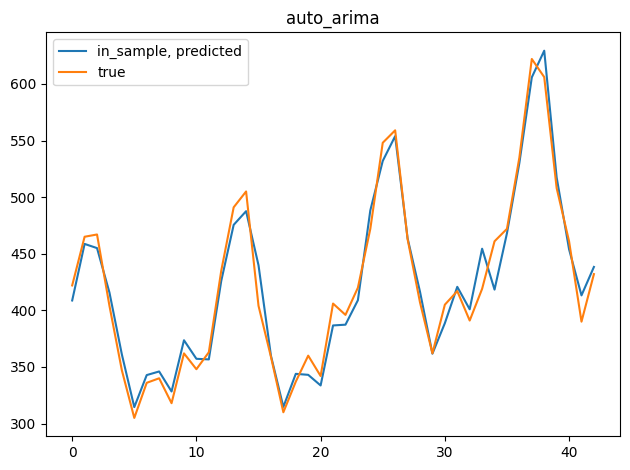

In [142]:
plt.plot(in_sample.reset_index(drop=True), label="in_sample, predicted")
plt.plot(ts_test.reset_index(drop=True), label="true")
plt.legend()
plt.title('auto_arima')
plt.tight_layout()
plt.show()

In [ ]:
ts_train, ts_test, in_sample, out_of_sample = make_pipeline_fullyconnected(
    long, 10, 2, 2, (10, 10), 10
)



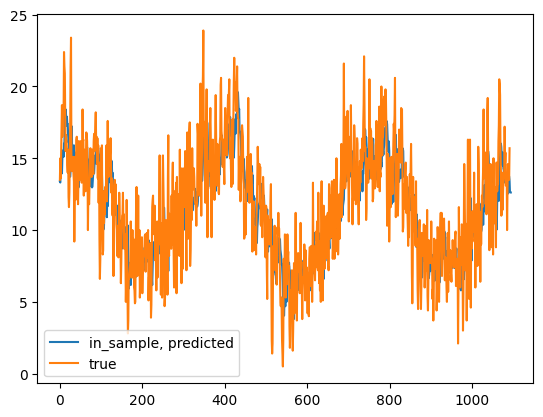

In [127]:
plt.plot(in_sample.reset_index(drop=True), label="in_sample, predicted")
plt.plot(ts_test[:,0], label="true")
plt.legend()
plt.show()